#Clone repository

In [1]:
!git clone https://github.com/hospitaldeamor/JC_07_CNN.git


Cloning into 'JC_07_CNN'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 7.53 MiB | 12.03 MiB/s, done.


#MRI tumor classification

##Import libraries

In [ ]:

from os import listdir
from skimage.transform import resize
from skimage.io import imread




from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc

In [40]:
import os
from os import listdir
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc

In [6]:
!unzip /content/JC_07_CNN/brain-mri-tumor-dataset/data.zip -d /content/JC_07_CNN/brain-mri-tumor-dataset/

#set up the directory
image_dir="/content/JC_07_CNN/brain-mri-tumor-dataset/data/"

Archive:  /content/JC_07_CNN/brain-mri-tumor-dataset/data.zip
   creating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/
   creating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/no/
  inflating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/no/1 no.jpeg  
  inflating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/no/10 no.jpg  
  inflating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/no/11 no.jpg  
  inflating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/no/12 no.jpg  
  inflating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/no/13 no.jpg  
  inflating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/no/14 no.jpg  
  inflating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/no/15 no.jpg  
  inflating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/no/17 no.jpg  
  inflating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/no/18 no.jpg  
  inflating: /content/JC_07_CNN/brain-mri-tumor-dataset/data/no/19 no.jpg  
  inflating: /content/JC_07_CNN/brain-mri-tumor-dat

##Preprocessing data

Function to load images from the directory and perform pre-processing, including:
* resizing to 240x240 mm
* normalizing the scale so that the intensity of the images is between 0 and 1 instead of 0 to 255 (grayscale)
* Turning the labels from categorical to numeric (without tumor = 0, with tumor = 1)

In [7]:
def load_data(dir_list, image_size=(240, 240)):  # Added image_size argument with default (224, 224)
    X = []
    y = []

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            # Resize image to the standard size
            image = cv2.resize(image, image_size, interpolation=cv2.INTER_CUBIC)
            # Normalize the image (optional, for better performance with neural networks)
            image = image / 255.0
            X.append(image)

            # Append label: 1 for 'yes' folder, 0 for 'no' folder
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

Processing to crop the image as much as possible to remove the black background and leave only the brain.

In [8]:
def crop_brain_contour(image, plot=False, target_size=(240, 240)):
    # Ensure the image is in uint8 format
    if image.dtype != 'uint8':
        image = (image * 255).astype('uint8')

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Use the grayscale image for Gaussian blur

    # Apply thresholding to get a binary image (single-channel)
    _, thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Ensure thresh is single-channel (grayscale) before passing to findContours
    if len(thresh.shape) == 3:
        thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)

    # Find contours in thresholded image, then grab the largest one
    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    # Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        new_image = image[y:y+h, x:x+w]
        break

    # Resize the cropped image to the target size
    new_image_resized = cv2.resize(new_image, target_size)

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image_resized)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image_resized

def Croping_Data(train, target_size=(240, 240)):
    # Load all images in a directory
    X = []
    y = []

    for img in train:
        if img.dtype != 'uint8':
            img = (img * 255).astype('uint8')  # Convert to uint8 if not already
        image = crop_brain_contour(img, plot=False, target_size=target_size)
        X.append(image)

    X = np.array(X)

    return X

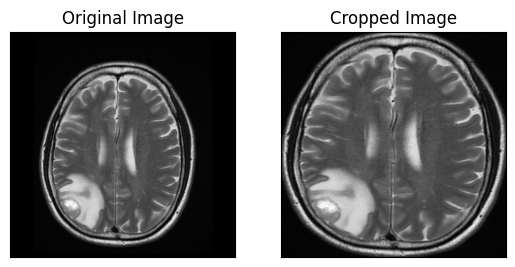

In [11]:
#Application in one image to test the crop function
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [12]:
#function to split dataset in train, validation and test
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [17]:
#load the data in the directory
X_train,y_train = load_data([image_dir+'yes', image_dir+'no'], image_size=(240, 240))

#preprocess the data
X = Croping_Data(X_train)
y = y_train

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [18]:
#Slip the dataset in train, validation and test
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

number of training examples = 177
number of validation examples = 38
number of test examples = 38
Training data and target sizes: 
(177, 240, 240, 3), (177, 1)
Test data and target sizes: 
(38, 240, 240, 3), (38, 1)


## MLP modeling

In [19]:
#Convert the images from 3D arrays (height, width, channels) to a 2D array
X_train_mlp = X_train.reshape(X_train.shape[0], 172800)
y_train_mlp = y_train.reshape(y_train.shape[0], )
print('Training data and target sizes: \n{}, {}'.format(X_train_mlp.shape,y_train_mlp.shape))

X_val_mlp = X_val.reshape(X_val.shape[0], 172800)
y_val_mlp = y_val.reshape(y_val.shape[0], )
print('Validation data and target sizes: \n{}, {}'.format(X_val_mlp.shape,y_train_mlp.shape))

X_test_mlp = X_test.reshape(X_test.shape[0], 172800)
y_test_mlp = y_test.reshape(y_test.shape[0], )
print('Test data and target sizes: \n{}, {}'.format(X_test_mlp.shape,y_test_mlp.shape))

Training data and target sizes: 
(177, 172800), (177,)
Validation data and target sizes: 
(38, 172800), (177,)
Test data and target sizes: 
(38, 172800), (38,)


In [20]:
mlp = Sequential()
mlp.add(Input(shape=(X_train_mlp.shape[1],)))
mlp.add(Dense(512, activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │      88,474,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,638,465 (338.13 MB)

 Trainable params: 88,638,465 (338.13 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
mlp.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(X_train_mlp, y_train_mlp, epochs=60, batch_size=32, validation_data=(X_val_mlp, y_val_mlp))

Epoch 1/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 551ms/step - accuracy: 0.5347 - loss: 7214.8105 - val_accuracy: 0.6053 - val_loss: 11166.1943
Epoch 2/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5276 - loss: 8888.8906 - val_accuracy: 0.6316 - val_loss: 169.9714
Epoch 3/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5572 - loss: 805.6108 - val_accuracy: 0.5526 - val_loss: 370.9812
Epoch 4/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6128 - loss: 595.0199 - val_accuracy: 0.6053 - val_loss: 1430.3691
Epoch 5/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6103 - loss: 873.3419 - val_accuracy: 0.5263 - val_loss: 529.7722
Epoch 6/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6645 - loss: 427.7139 - val_accuracy: 0.5789 - val_loss: 311.5770
Epoch 7/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7162 - loss: 240.9323 - val_accuracy: 0.5263 - val_loss: 409.4228
Epoch 8/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6621 - loss: 250.8128 - val_

##CNN modeling

In [29]:
#Initialize the CNN model
cnn = Sequential()
cnn.add(Conv2D(32, (3,3), activation = 'relu', input_shape =(240, 240, 3))) # Add first convolutional layer
cnn.add(MaxPooling2D(2,2)) # Add first max pooling layer
cnn.add(Conv2D(64, (3,3), activation = 'relu')) # Add second convolutional layer
cnn.add(MaxPooling2D(2,2)) # Add second max pooling layer
cnn.add(Conv2D(128, (3,3), activation = 'relu')) # Add third convolutional layer
cnn.add(MaxPooling2D(2,2)) # Add third max pooling layer
cnn.add(Flatten()) # Flatten the output from the convolutional layers to feed into fully connected layers
cnn.add(Dense(128, activation = 'relu')) # Add a dense fully connected layer
cnn.add(Dropout(0.3)) # Add dropout layer to prevent overfitting
cnn.add(Dense(1, activation = 'sigmoid')) # Add output layer (for binary classification, sigmoid activation)
cnn.summary() # Display the model architecture summary

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 238, 238, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 119, 119, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 117, 117, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
#Compile the CNN model
cnn.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics = ['accuracy'])

# Train the CNN model with the training data and validation data
cnn.fit(X_train, y_train, validation_data = (X_val, y_val), verbose=1, epochs=100)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 721ms/step - accuracy: 0.5385 - loss: 23.7571 - val_accuracy: 0.6053 - val_loss: 9.4139
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5748 - loss: 8.6160 - val_accuracy: 0.5526 - val_loss: 2.7133
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6031 - loss: 3.3172 - val_accuracy: 0.6053 - val_loss: 2.4114
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6974 - loss: 1.5805 - val_accuracy: 0.6316 - val_loss: 1.1947
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7215 - loss: 0.9422 - val_accuracy: 0.6579 - val_loss: 0.8608
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8241 - loss: 0.4520 - val_accuracy: 0.7368 - val_loss: 0.6111
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8767 - loss: 0.2646 - val_accuracy: 0.7368 - val_loss: 0.5842
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9295 - loss: 0.1753 - val_accuracy: 0.7368 - val_los

### Variations

In [33]:
cnn = Sequential()
cnn.add(Conv2D(32, (3,3), activation = 'relu', input_shape =(240, 240, 3)))
cnn.add(MaxPooling2D(2,2))
cnn.add(Conv2D(64, (3,3), activation = 'relu'))
cnn.add(MaxPooling2D(2,2))
cnn.add(Conv2D(128, (3,3), activation = 'relu'))
cnn.add(MaxPooling2D(2,2))
cnn.add(Conv2D(256, (3,3), activation = 'relu'))
cnn.add(MaxPooling2D(2,2))
cnn.add(Flatten())
cnn.add(Dense(256, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(1, activation = 'sigmoid'))
cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 238, 238, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 119, 119, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 117, 117, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 26, 26, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      11,075,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,464,513 (43.73 MB)

 Trainable params: 11,464,513 (43.73 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss (or you can use 'val_accuracy')
    patience=10,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True,  # Restore the best weights after stopping
    verbose=1             # Display when early stopping is triggered
)

# Compile the model
cnn.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model with early stopping
cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=1, callbacks=[early_stopping])


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 528ms/step - accuracy: 0.9598 - loss: 0.1348 - val_accuracy: 0.7105 - val_loss: 1.7141
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9702 - loss: 0.0813 - val_accuracy: 0.7105 - val_loss: 1.2285
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9975 - loss: 0.0107 - val_accuracy: 0.8158 - val_loss: 1.0021
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0235 - val_accuracy: 0.7368 - val_loss: 1.1140
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.7895 - val_loss: 1.0947
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.7895 - val_loss: 1.1302
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.7895 - val_loss: 1.1990
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.7895 - val_loss

##Evaluation

In [36]:
# Evaluate on test data
test_loss_mlp, test_acc_mlp = mlp.evaluate(X_test_mlp, y_test_mlp)
print(f"Test accuracy: {test_acc_mlp}")

test_loss_cnn, test_acc_cnn = cnn.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc_cnn}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6223 - loss: 330.8344
Test accuracy: 0.6052631735801697
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7621 - loss: 1.2028
Test accuracy: 0.7368420958518982


In [37]:
# Make predictions for MLP model
y_pred_mlp = mlp.predict(X_test_mlp)
y_pred_mlp = (y_pred_mlp > 0.5).astype(int)  # Convert to 0 or 1

# Make predictions for CNN model
y_pred_cnn = cnn.predict(X_test)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)  # Convert to 0 or 1

# Print classification report for MLP
print("Classification Report for MLP:")
print(classification_report(y_test_mlp, y_pred_mlp))

# Print classification report for CNN
print("Classification Report for CNN:")
print(classification_report(y_test, y_pred_cnn))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step
Classification Report for MLP:
              precision    recall  f1-score   support

           0       0.52      0.69      0.59        16
           1       0.71      0.55      0.62        22

    accuracy                           0.61        38
   macro avg       0.61      0.62      0.60        38
weighted avg       0.63      0.61      0.61        38

Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        16
           1       0.80      0.73      0.76        22

    accuracy                           0.74        38
   macro avg       0.73      0.74      0.73        38
weighted avg       0.74      0.74      0.74        38



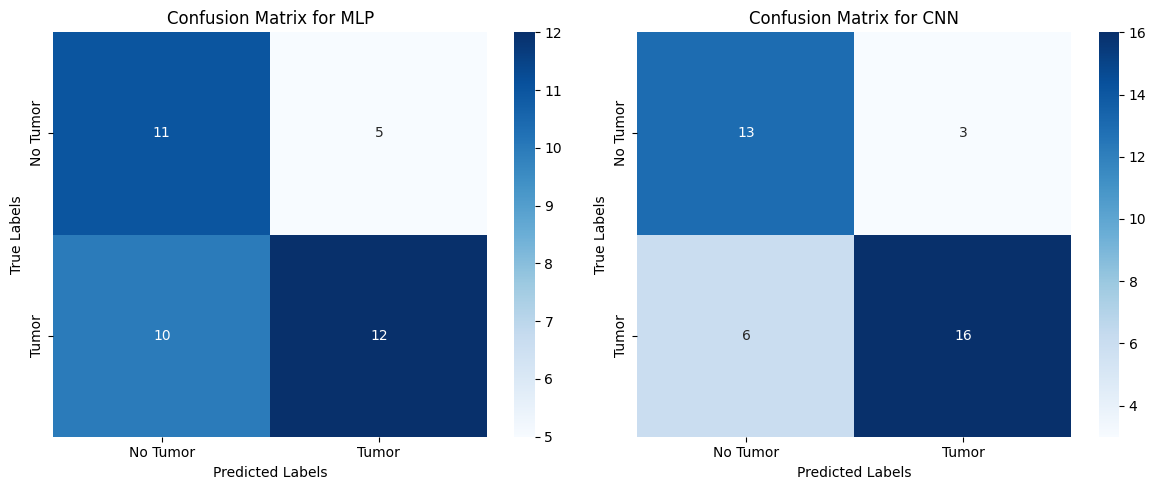

In [26]:
# Compute confusion matrix for MLP
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

# Compute confusion matrix for CNN
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# Create a figure with 1 row and 2 columns for side-by-side plots
plt.figure(figsize=(12, 5))

# Subplot 1: Confusion Matrix for MLP
plt.subplot(1, 2, 1)  # (rows, columns, index)
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for MLP')

# Subplot 2: Confusion Matrix for CNN
plt.subplot(1, 2, 2)  # (rows, columns, index)
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CNN')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

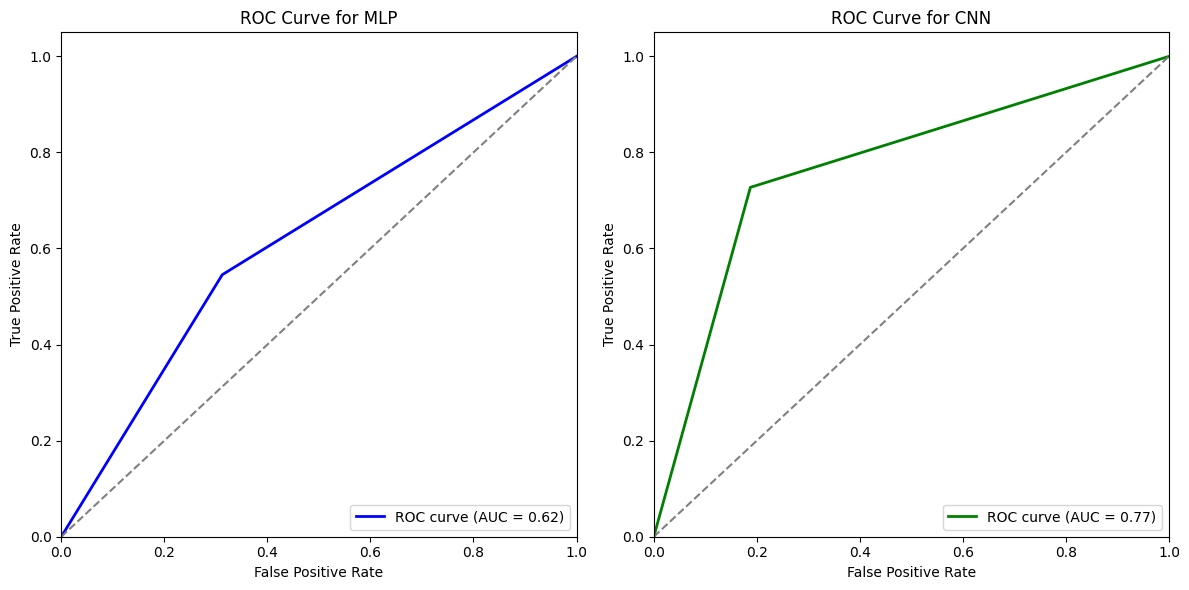

In [27]:
# Compute ROC curve for MLP
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_pred_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Compute ROC curve for CNN
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Create a figure with 1 row and 2 columns for side-by-side ROC curve plots
plt.figure(figsize=(12, 6))

# Subplot 1: ROC curve for MLP
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(fpr_mlp, tpr_mlp, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (chance)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP')
plt.legend(loc='lower right')

# Subplot 2: ROC curve for CNN
plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.plot(fpr_cnn, tpr_cnn, color='g', lw=2, label=f'ROC curve (AUC = {roc_auc_cnn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (chance)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc='lower right')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()
